# Regrese 1

## Cvičení 2
 
### Vytvořte polynomiální regresní model

**Popis datasetu (`manufacturing.csv`):**

- **Teplota (°C):** Teplota během výroby.  
- **Tlak (kPa):** Tlak aplikovaný během výroby.  
- **Teplota × Tlak:** Interakční termín.  
- **Materiálová fúze:** Odvozená metrika `T² + P³`.  
- **Transformace materiálu:** Odvozená metrika `T³ − P²`.  
- **Hodnocení kvality:** Cílová proměnná.

**Cíl úlohy:**

- Analyzovat vztahy mezi parametry výrobního procesu a kvalitou výrobků.  
- Vytvořit polynomické regresní modely různých stupňů.  
- Optimalizovat stupeň polynomu podle regresních metrik (MSE, RMSE, R-squared).  
- Porovnat výkonnost modelů a vizualizovat výsledky.

In [1]:
import gdown
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('default')
sns.set_style("whitegrid")

datasets_dir = Path("datasets")
datasets_dir.mkdir(exist_ok=True)
dataset = datasets_dir / "manufacturing.csv"
dataset_url = "https://drive.google.com/drive/folders/1hXRpUJKJRl4DhuprUaQMXWuXPwx69yy0"

if not dataset.exists():
    gdown.download_folder(url=dataset_url, output=str(datasets_dir), use_cookies=False)

df = pd.read_csv(dataset)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Temperature (°C)                3957 non-null   float64
 1   Pressure (kPa)                  3957 non-null   float64
 2   Temperature x Pressure          3957 non-null   float64
 3   Material Fusion Metric          3957 non-null   float64
 4   Material Transformation Metric  3957 non-null   float64
 5   Quality Rating                  3957 non-null   float64
dtypes: float64(6)
memory usage: 185.6 KB


,Temperature (°C),Pressure (kPa),Temperature x Pressure,Material Fusion Metric,Material Transformation Metric,Quality Rating
count,3957.000000,3957.000000,3957.000000,3957.000000,3.957000e+03,3957.000000
mean,200.034704,14.815558,2955.321308,48127.183128,1.003645e+07,96.260179
std,58.135717,5.772040,1458.224940,23812.213513,7.599356e+06,12.992262
min,100.014490,5.003008,513.706875,10156.971955,9.999462e+05,1.000000
25%,150.871296,9.692984,1798.247303,27626.929091,3.433810e+06,99.941129
50%,198.603371,14.832557,2678.277782,44611.452164,7.833390e+06,99.999997
75%,251.366552,19.749680,3929.058261,67805.443846,1.588251e+07,100.000000
max,299.992804,24.999132,7365.018714,103756.181544,2.699783e+07,100.000000


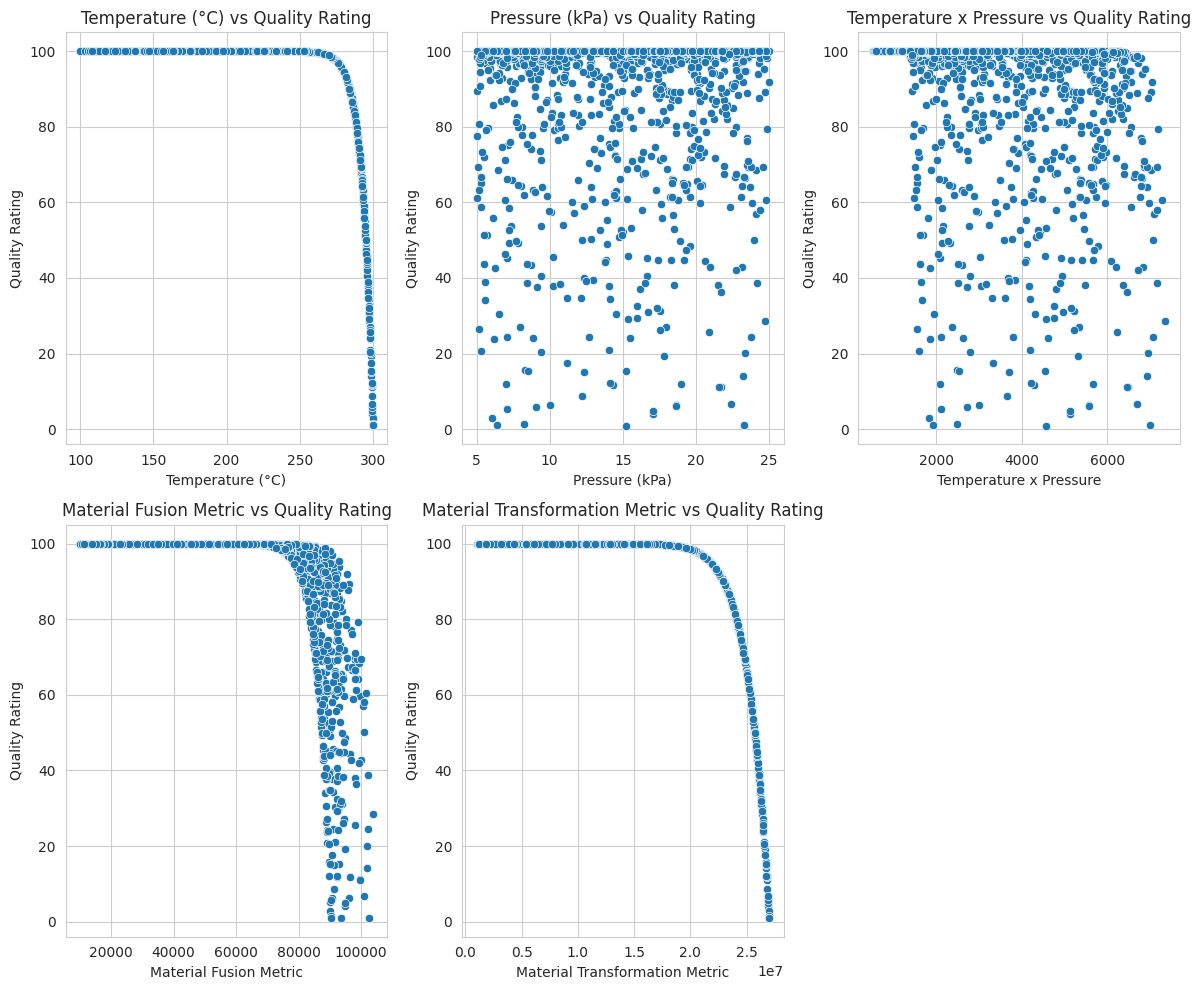

In [2]:
y_col = "Quality Rating"

# Seznam vstupních proměnných
input_columns = [col for col in df.columns if col != y_col]

# Vytvoření mřížky 2x3
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# Smyčka přes vstupní proměnné
for i, column in enumerate(input_columns):
    sns.scatterplot(x=column, y=y_col, data=df, ax=axes[i])
    axes[i].set_title(f'{column} vs {y_col}')
    axes[i].grid(True)

# Skrytí nevyužitých subplotů (když je méně než 4 vstupní sloupce)
for j in range(len(input_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [3]:
def run_regressions(df, x_col, y_col, test_size=0.3, random_state=42, max_poly_degree=3):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import Ridge
    
    X = df[[x_col]].values
    y = df[y_col].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- Polynomial Regression for each degree ---
    poly_results = []

    for degree in range(1, max_poly_degree + 1):
        # Use Ridge regression with regularization to prevent overfitting
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=1.0))
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Calculate AIC for model selection (penalizes complexity)
        n = len(y_test)
        k = degree + 1  # number of parameters
        aic = n * np.log(mse) + 2 * k
        
        metrics = {
            "MSE": mse,
            "RMSE": np.sqrt(mse),
            "MAE": mean_absolute_error(y_test, y_pred),
            "R2": r2,
            "AIC": aic
        }

        poly_results.append({
            "degree": degree,
            "model": pipeline,
            "metrics": metrics
        })

    # Choose best polynomial by AIC (lower is better, balances fit and complexity)
    best_poly = min(poly_results, key=lambda r: r["metrics"]["AIC"])

    return poly_results, best_poly

for col in input_columns:
    poly_results, best_poly = run_regressions(df, col, y_col)

    print(f"\n[{col}] Polynomial Regression (per degree):")
    for result in poly_results:
        deg = result["degree"]
        m = result["metrics"]
        print(f"  Degree {deg} -> MSE: {m['MSE']:.3f}, RMSE: {m['RMSE']:.3f}, "
              f"MAE: {m['MAE']:.3f}, R2: {m['R2']:.3f}")

    best_deg = best_poly["degree"]
    best_m = best_poly["metrics"]
    print(f"\n[{col}] Best Polynomial Degree: {best_deg}")
    print(f"  MSE: {best_m['MSE']:.3f}, RMSE: {best_m['RMSE']:.3f}, "
          f"MAE: {best_m['MAE']:.3f}, R2: {best_m['R2']:.3f}")



[Temperature (°C)] Polynomial Regression (per degree):
  Degree 1 -> MSE: 157.726, RMSE: 12.559, MAE: 6.661, R2: 0.213
  Degree 2 -> MSE: 108.164, RMSE: 10.400, MAE: 5.819, R2: 0.460
  Degree 3 -> MSE: 89.812, RMSE: 9.477, MAE: 5.145, R2: 0.552

[Temperature (°C)] Best Polynomial Degree: 3
  MSE: 89.812, RMSE: 9.477, MAE: 5.145, R2: 0.552

[Pressure (kPa)] Polynomial Regression (per degree):
  Degree 1 -> MSE: 201.020, RMSE: 14.178, MAE: 6.600, R2: -0.003
  Degree 2 -> MSE: 200.989, RMSE: 14.177, MAE: 6.599, R2: -0.003
  Degree 3 -> MSE: 200.916, RMSE: 14.174, MAE: 6.598, R2: -0.003

[Pressure (kPa)] Best Polynomial Degree: 1
  MSE: 201.020, RMSE: 14.178, MAE: 6.600, R2: -0.003

[Temperature x Pressure] Polynomial Regression (per degree):
  Degree 1 -> MSE: 183.802, RMSE: 13.557, MAE: 6.042, R2: 0.083
  Degree 2 -> MSE: 179.018, RMSE: 13.380, MAE: 5.867, R2: 0.106
  Degree 3 -> MSE: 176.569, RMSE: 13.288, MAE: 5.788, R2: 0.119

[Temperature x Pressure] Best Polynomial Degree: 3
  MSE:

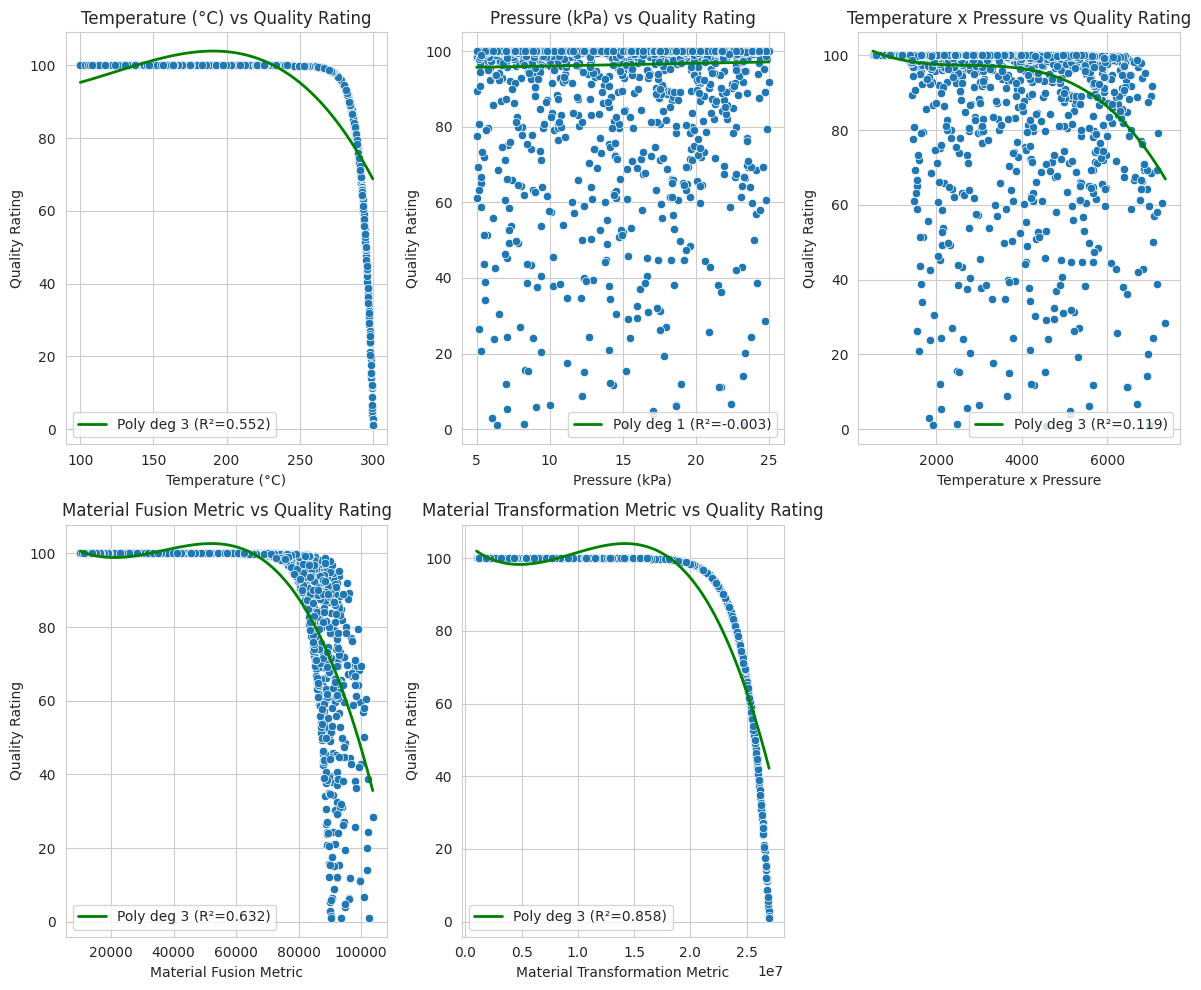

In [4]:
y_col = "Quality Rating"

# Seznam vstupních proměnných
input_columns = [col for col in df.columns if col != y_col]

# Vytvoření mřížky 2x3
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# Smyčka přes vstupní proměnné
for i, column in enumerate(input_columns):
    # Scatter plot
    sns.scatterplot(x=column, y=y_col, data=df, ax=axes[i])
    
    # Run polynomial regression for this column
    poly_results, best_poly = run_regressions(df, column, y_col)
    
    # Generate smooth line for plotting
    x_range = np.linspace(df[column].min(), df[column].max(), 100)
    y_pred_range = best_poly["model"].predict(x_range.reshape(-1, 1))
    
    # Plot regression line in green
    axes[i].plot(x_range, y_pred_range, 'g-', linewidth=2, 
                label=f'Poly deg {best_poly["degree"]} (R²={best_poly["metrics"]["R2"]:.3f})')
    
    axes[i].set_title(f'{column} vs {y_col}')
    axes[i].grid(True)
    axes[i].legend()

# Skrytí nevyužitých subplotů
for j in range(len(input_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()